# TGS Salt Identification Challenge

Karl Heyer

This notebook details my solutions to Kaggle's [TGS Salt Identification Challenge](https://www.kaggle.com/c/tgs-salt-identification-challenge). I found this to be a challenging problem due to the size of training dataset - 4000 images. I tried a number of tricks with augmentation but still ended up around the middle of the pack leaderboard-wise. I'm looking forward to seeing the winning solutions. I think there will be a lot to learn from them in terms of image processing and augmentation.

## Contents

1. Model Architecture
2. Data Setup
3. Resnet34 Models
4. VGG16 Models
5. Resnext50 Models
6. Prediction
7. Afterthoughts

# 1. Model Architecture

The goal of this challenge is to produce segmentation masks to identify salt deposits in seismic images. To do this, we are going to use a U-Net model.

We want the model to process the image, then return a mask of the same size as the original image. One way to go about doing this would be to first use a convolutional model as an encoder to process the input image into a smaller, deeper tensor. Then use a decoder to upsample from that convolutional output back to the original image size. This strategy works, but only so well. The issue is that a huge amount of information in the input is compressed into the convolutional output of the encoder. Trying to decompress this with the degree of accuracy required for masking is very challenging. Good masks require fine detail at the edges - precise boundaries are important. Trying to retain this information through the convolutional encoder is simply hard.

U-Net provides a solution to this. A U-Net model saves activations from earlier layers in the encoder and passes them to the decoder during upsampling. This allows the decoder to retain image information from early convolutional layers. This architecture is much more proficient at producing high quality masks. Visually, the U-Net looks like this:[](attachment:ssd_arch.png)

<img src="unet.png">

[source](https://arxiv.org/pdf/1505.04597.pdf)

## Pretrained Encoders

One way to jump start the performance of a U-Net model is to use a pretrained model for the encoder. Pretrained models have already developed the weights required for fundamental image processing functions like edge and texture detection. These benefits carry over to even distant image recognition tasks, like processing seismic imaging.

In this notebook we will look at 3 different pretrained encoders - Resnet34, VGG16, and Resnext50.

## Loss Function

Segmentation can be viewed as a classification problem - you want to classify every pixel in the input image as either a 0 or 1 depending on if it is part of the mask or not. A simple loss function that works for this task would be binary cross entropy. However we can get better performance if we add on to that.

When it comes to producing high quality masks, the difficulty is on the edge of the mask. The inside of the mask has a bunch of pixels classified as 1 all grouped together. Outside of the mask, every pixel is classified as 0. Classifying the bulk of the inside of the mask 1 and the bulk of the outside as 0 is fairly easy. The difficulty in segmentation happens on the boundaries, where the mask transitions from mostly 1s to mostly 0s. Visually speaking, creating blobby ill defined masks is easy. Creating masks with sharp, accurate, well defined edges is hard.

To push the model towards paying attention to the boundaries, we add a soft dice loss component to the loss function. The dice score looks at how similar the predicted mask is to the target mask by looking at the ratio of true positives to true positives plus false positives plus false negatives. For numerical stability, we add the natural log of the dice score to the loss function.

# 2. Data Setup

This project uses Pytorch, fast.ai and associated libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
torch.cuda.set_device(1)

In [4]:
torch.backends.cudnn.benchmark=True

In [5]:
PATH = Path('C:/Users/GATEWAY/Projects/FastAI/data/salt')

The competition provides us with training images and two csv files. train.csv contains RLE encoded masks for the training images. depths.csv contains depth information for training images.

In [6]:
df = pd.read_csv(PATH/'train.csv')

In [7]:
df.head(10)

,id,rle_mask
0,575d24d81d,NaN
1,a266a2a9df,5051 5151
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...
5,782ae9b7e7,1 1815 1819 90 1920 81 2021 73 2122 64 2223 55...
6,9842f69f8d,NaN
7,aa94cfb806,1 28 102 28 203 29 304 30 405 32 506 33 607 34...
8,50d3073821,1 2121 9293 909
9,28f865caaa,NaN


Each image has a single mask associated with it.

In [8]:
sum(df.id.value_counts() > 1)

0

In [9]:
trn_fns = os.listdir(PATH/'train/images/')

In [10]:
mask_fns = os.listdir(PATH/'train/masks/')

In [11]:
TRAIN_DN = 'train/images'

In [12]:
MASKS_DN = 'train/masks'

In [13]:
x_names = np.array([Path(TRAIN_DN)/o for o in trn_fns])
y_names = np.array([Path(MASKS_DN)/o for o in mask_fns])

Here we separate our validation set. I'm taking 10% of the images instead of my usual 20%. The dataset is small enough that shifting 10% (400 images) to the training set makes a difference for performance

In [14]:
n = len(x_names)

In [15]:
val_idxs = get_cv_idxs(n, val_pct=0.1)

In [16]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

Test images are 101x101x3 arrays. Masks are single channel 101x101 arrays.

In [17]:
test_x = PIL.Image.open(PATH/x_names[0])
np.array(test_x).shape

(101, 101, 3)

In [18]:
test_y = PIL.Image.open(PATH/y_names[0])
np.array(test_y).shape

(101, 101)

In [19]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [20]:
ims = [open_image(PATH/x_names[i]) for i in range(16)]
im_masks = [open_image(PATH/y_names[i]) for i in range(16)]

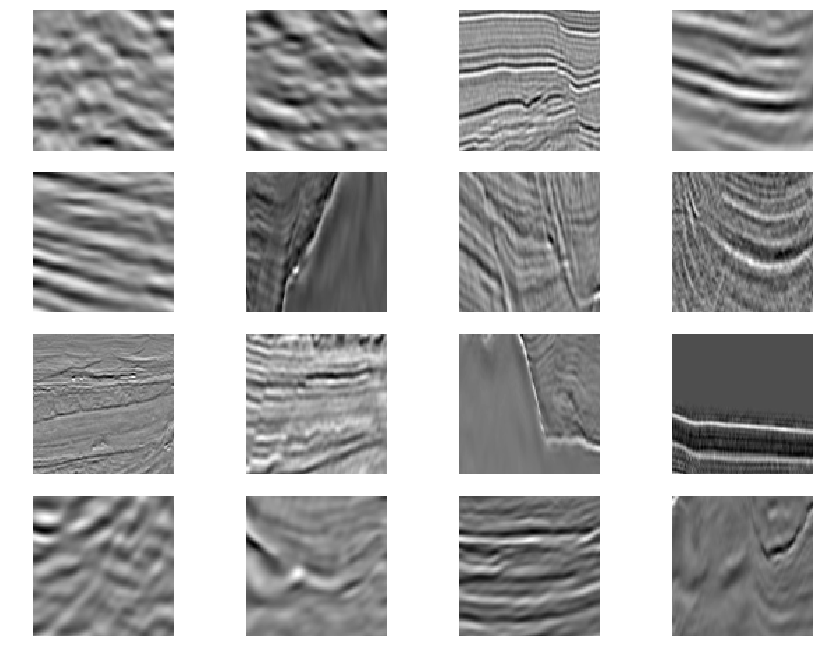

In [21]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
plt.tight_layout(pad=0.1)

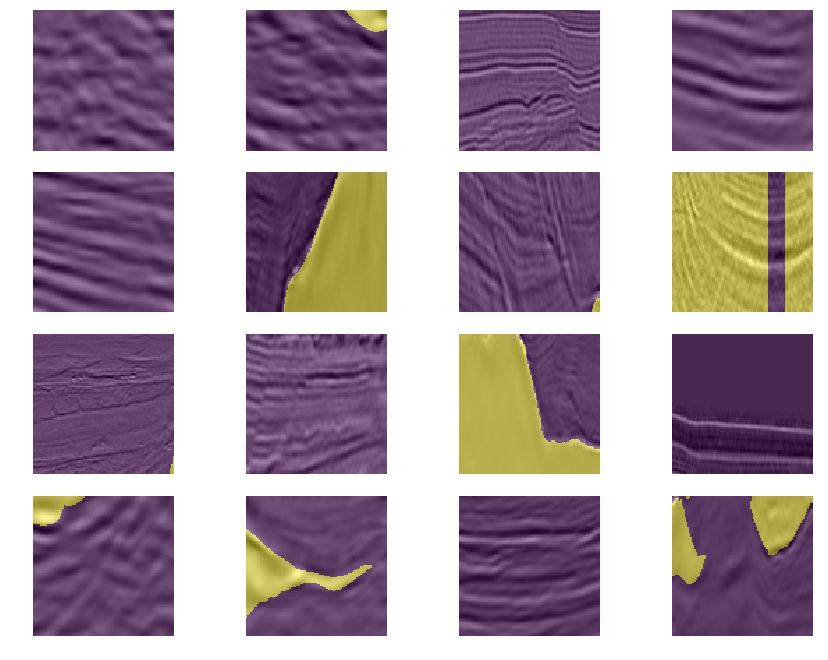

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

Honeslty I can't make heads or tails of these masks. Some seem to make sense. I can see a clear boundry line in the black and white image. Others just seem random. 

This mask I can make sense of. There's a clear boundry line between the salt deposit and the rest of the material. The salt deposit has a distinct texture.

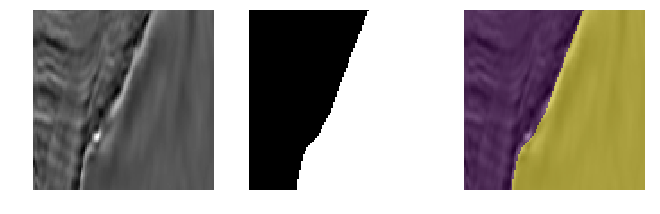

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 5

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

Here's another sensible mask

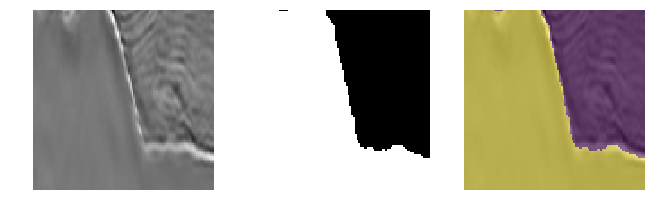

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 10

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

This mask makes no sense to me. Why would there be that stripe going through the center? Are there mistakes in the mask? Should this image be considered entirely salt?

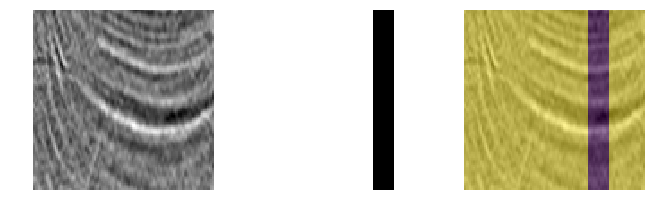

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 7

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

I expect issues with this type of mask. The entire correct mask is black, except for a tiny fraction in the bottom corner.

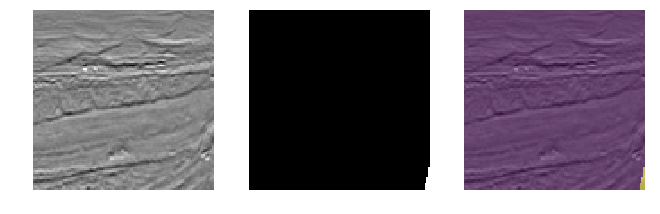

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 8

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

This mask is interesting. There appears to be a clear change in texture, but no salt is identified in the mask. Something else must be going on.

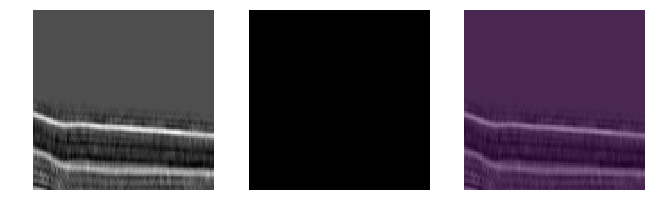

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 11

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

This mask I can make sense of after the fact. It definitely seems tricky though.

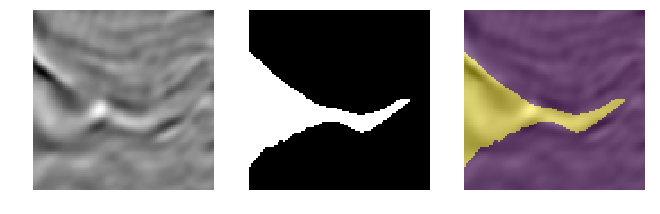

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3))

im_val = 13

axes[0] = show_img(ims[im_val], ax=axes[0])
axes[1] = show_img(im_masks[im_val], ax=axes[1])
axes[2] = show_img(ims[im_val], ax=axes[2])
show_img(im_masks[im_val][...,0], ax=axes[2], alpha=0.5)
plt.tight_layout(pad=0.1)

I don't see any obvious patterns that clearly indicate where a mask should be. I can only hope my neural network is able to prevail where my human intuition fails.

# 3. Resnet34 Models

The first pretrained model we will try is Resnet34, trained on Imagenet. First we set up our dataloader and image augmentations.

In [29]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [30]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS)]

In [31]:
sz = 128
bs = 32

tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

Lets check that the dataloader and image augmentation is working correctly.

In [32]:
x,y = next(iter(md.trn_dl))

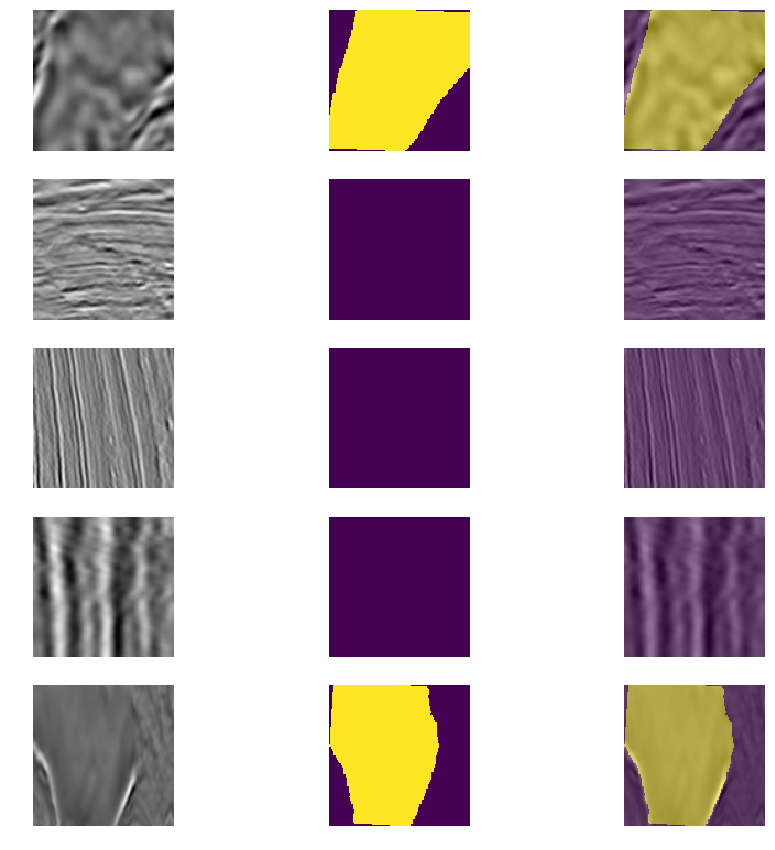

In [33]:
fig, axes = plt.subplots(5 , 3, figsize = (15,15))

for i in range(5):
    axes[i][0] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i], ax = axes[i][1])
    axes[i][2] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][2])
    axes[i][2] = show_img(y[i], ax = axes[i][2], alpha=0.5)

In [34]:
batches = [next(iter(md.aug_dl)) for i in range(5)]

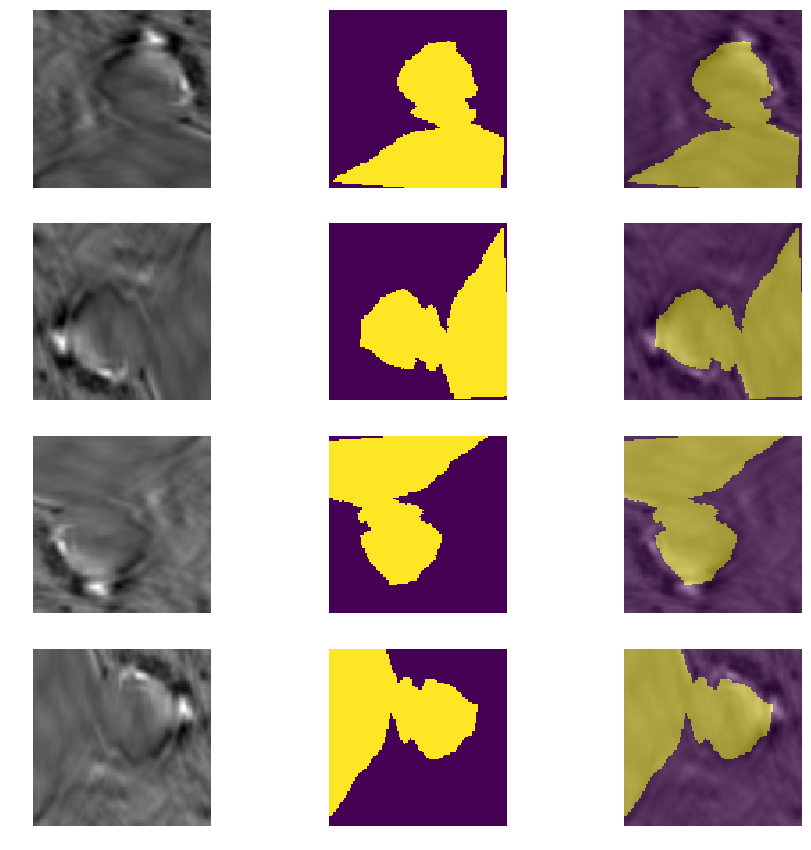

In [35]:
fig, axes = plt.subplots(4 , 3, figsize = (15,15))

it = enumerate(batches)
for i in range(4):
    j, (x_a, y_a) = next(it)
    
    axes[i][0] = show_img(denorm(x_a[7]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y_a[7], ax = axes[i][1])
    axes[i][2] = show_img(denorm(x_a[7]).squeeze(0), ax = axes[i][2])
    axes[i][2] = show_img(y_a[7], ax = axes[i][2], alpha=0.5)

I am a little concerned about how slight rotations lead to effects near the edge of the mask. Rotation doesn't seem to work well with masks that go to the edge of the image. 

Trying again without rotation:

In [36]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS)]

In [37]:
sz = 128
bs = 32

tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [38]:
x,y = next(iter(md.trn_dl))

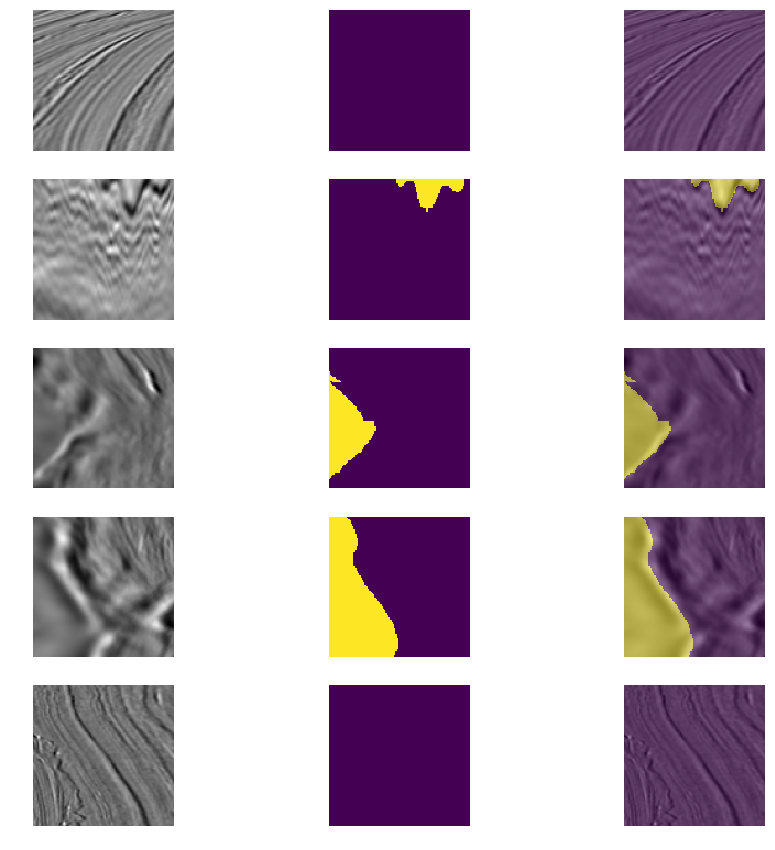

In [39]:
fig, axes = plt.subplots(5 , 3, figsize = (15,15))

for i in range(5):
    axes[i][0] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i], ax = axes[i][1])
    axes[i][2] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][2])
    axes[i][2] = show_img(y[i], ax = axes[i][2], alpha=0.5)

In [40]:
batches = [next(iter(md.aug_dl)) for i in range(5)]

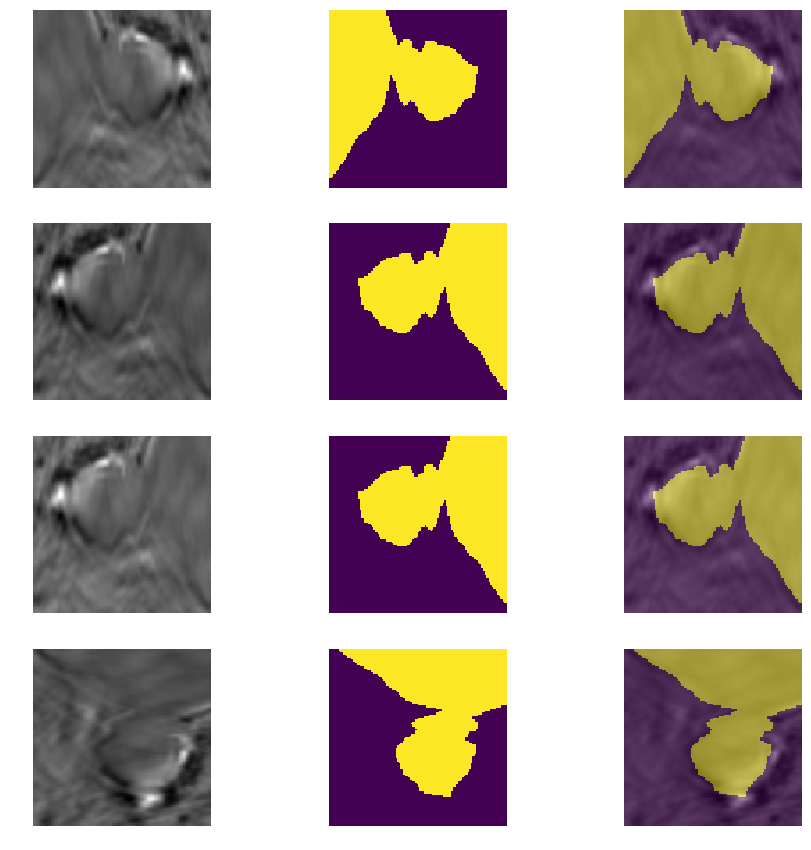

In [41]:
fig, axes = plt.subplots(4 , 3, figsize = (15,15))

it = enumerate(batches)
for i in range(4):
    j, (x_a, y_a) = next(it)
    
    axes[i][0] = show_img(denorm(x_a[7]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y_a[7], ax = axes[i][1])
    axes[i][2] = show_img(denorm(x_a[7]).squeeze(0), ax = axes[i][2])
    axes[i][2] = show_img(y_a[7], ax = axes[i][2], alpha=0.5)

That looks better.

## Resnet34 Basic U-Net Model

We will build a basic U-Net model. The model uses forward hooks to grab activations from the Resnet34 encoder and transpose convolutions for upsampling.

In [42]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [43]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [44]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

This is our basic U-Net block. The block takes in activations from the previous layer as `up_p` and upsamples them with a transpose convolution. The block also takes activations from an encoder layer as `x_p`, and passes them through a convolution with a kernel size of 1. The outputs from these two convolutions are concatenated then passes through a Relu function and a batchnorm layer.

In [45]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [46]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [47]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

So we create our encoder

In [48]:
f = resnet34
cut,lr_cut = model_meta[f]

In [49]:
m_base = get_base()

An example of how forward hooks can be used to grab activations

In [50]:
sf = [SaveFeatures(children(m_base)[i]) for i in [2,4,5,6]]

In [51]:
out = m_base(V(x[:2]).cpu())

In [52]:
[i.features.size() for i in sf]

[torch.Size([2, 64, 64, 64]),
 torch.Size([2, 64, 32, 32]),
 torch.Size([2, 128, 16, 16]),
 torch.Size([2, 256, 8, 8])]

In [53]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [54]:
def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

In [55]:
def dice_loss(pred, target):
    loss_fn = nn.BCEWithLogitsLoss()
    bce_loss = loss_fn(pred, target)
    dice_loss = torch.log(dice(pred, target))
    loss = 2*bce_loss - dice_loss
    return loss

In [56]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5), dice, IoU]

In [57]:
learn.freeze_to(1)

 83%|██████████████████████████████████████████████████████████▏           | 94/113 [00:12<00:02,  7.77it/s, loss=2.84]

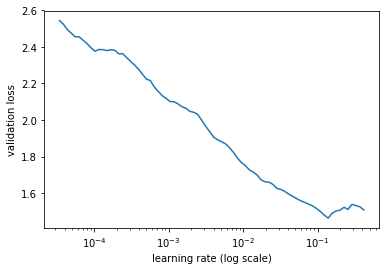

In [58]:
learn.lr_find()
learn.sched.plot()

In [58]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [59]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.922377   1.291762   0.84064    0.688884   0.529945  
    1      0.778901   0.655798   0.91576    0.804175   0.676488                                                        
    2      0.646386   0.572444   0.924815   0.83047    0.713727                                                        
    3      0.603751   0.535882   0.929444   0.838401   0.725906                                                        
    4      0.602827   0.582775   0.924702   0.819742   0.699272                                                        
    5      0.543483   0.498345   0.930385   0.84898    0.741468                                                        
    6      0.520818   0.522624   0.927809   0.839475   0.728299                                                        
    7      0.482651   0.504922   0.934283   0.852435   0.747597                               

[0.454866304397583, 0.9322561645507812, 0.861054289340973, 0.7611382865905761]

In [60]:
learn.unfreeze()
learn.bn_freeze(True)

In [61]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.421823   0.464981   0.938222   0.870786   0.776938  
    1      0.41733    0.443514   0.941886   0.87212    0.778408                                                        
    2      0.410954   0.441557   0.940823   0.872956   0.780217                                                        
    3      0.394729   0.411642   0.937942   0.876931   0.785945                                                        
    4      0.364148   0.482869   0.936438   0.861942   0.762824                                                        
    5      0.365137   0.436569   0.939039   0.867445   0.771348                                                        
    6      0.348929   0.437412   0.94091    0.871464   0.778167                                                        
    7      0.331328   0.418879   0.942729   0.873499   0.781336                               

[0.43257703840732575,
 0.940626220703125,
 0.8724870753288269,
 0.7794333171844482]

Lets see what the predicted masks look like.

In [62]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

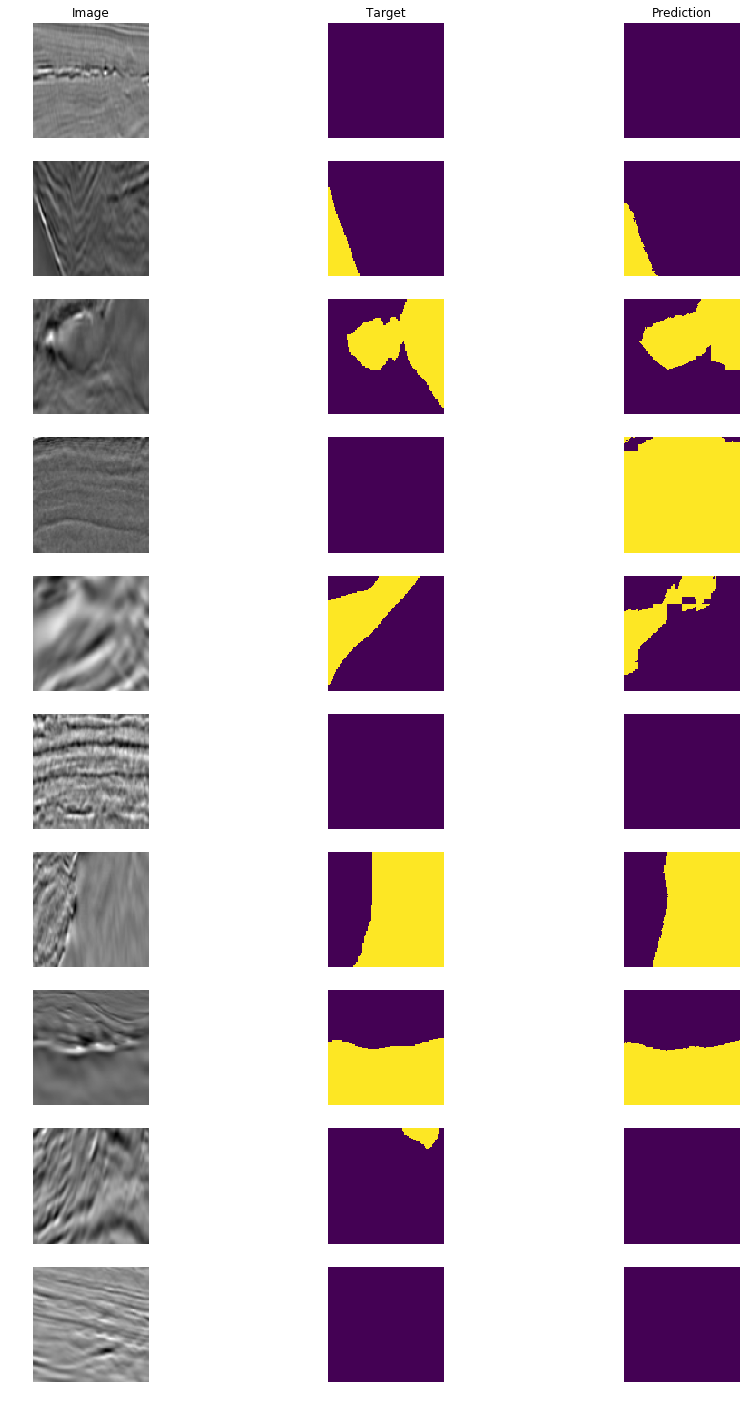

In [76]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

The predictions look okay. For a good number of them the model has predicted basically the right shape. Many of the empty masks are correctly predicted. I see 3 main failure modes:

In some cases the model predicts a full image mask for an empty mask

In some cases the prediction blob has chunks missing from it. This may be fixable by tuning the prediction cutoff.

In some cases, a small mask region on the edge of the image is missed and the image is called an empty mask.

## Resnet34 Deeper Decoder

The last model got to a dice score of 0.888. In the last model, the findal U-Net block with 256 channels went right into a transpose convolution that output the single channel mask. In the [U-Net Paper](https://arxiv.org/pdf/1505.04597.pdf), several convolutions are done between the final upsample and the output mask. Lets try adding some layers to see if it improves performance.


In [58]:
def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return nn.Sequential(*[
                        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.ReLU(),
                        nn.BatchNorm2d(out_c)])

In [59]:
class Unet34_2(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        self.conv1 = conv_bn_relu(128, 64, 3, 1, 1)
        self.conv2 = conv_bn_relu(64, 64, 3, 1, 1)
        self.conv3 = conv_bn_relu(64, 1, 1, 1, 0)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [60]:
m_base = get_base()
m = to_gpu(Unet34_2(m_base))
models = UnetModel(m)

In [61]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5), dice, IoU]

In [62]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.303132   10146.131797 0.609579   0.534771   0.367654  


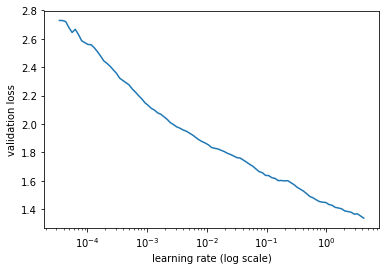

In [71]:
learn.lr_find()
learn.sched.plot()

In [82]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [83]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.051713   0.964088   0.8865     0.708895   0.557624  
    1      0.835775   0.931636   0.872025   0.733976   0.585718                                                        
    2      0.705732   0.603446   0.924018   0.82457    0.705765                                                        
    3      0.682454   0.572319   0.922116   0.825797   0.70672                                                         
    4      0.615667   0.775304   0.907588   0.79665    0.666818                                                        
    5      0.562804   0.498543   0.932089   0.851899   0.746567                                                        
    6      0.555854   0.500704   0.930846   0.852946   0.749083                                                        
    7      0.521324   0.458652   0.937402   0.864705   0.767329                               

[0.44320061326026916,
 0.9410763549804687,
 0.8727323913574219,
 0.778968915939331]

In [84]:
learn.unfreeze()
learn.bn_freeze(True)

In [85]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.454305   0.435315   0.943996   0.879378   0.788782  
    1      0.459103   0.446774   0.937453   0.870534   0.776574                                                        
    2      0.411859   0.443516   0.94463    0.877459   0.78634                                                         
    3      0.404552   0.438932   0.937061   0.870455   0.774762                                                        
    4      0.380591   0.446422   0.94006    0.865814   0.768857                                                        
    5      0.358264   0.397109   0.944848   0.883496   0.796009                                                        
    6      0.357406   0.457186   0.939009   0.87015    0.775541                                                        
    7      0.348945   0.414348   0.943391   0.876778   0.785144                               

[0.41378697991371155,
 0.9436228942871093,
 0.8778144931793213,
 0.7869744992256165]

Prediction masks:

In [86]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

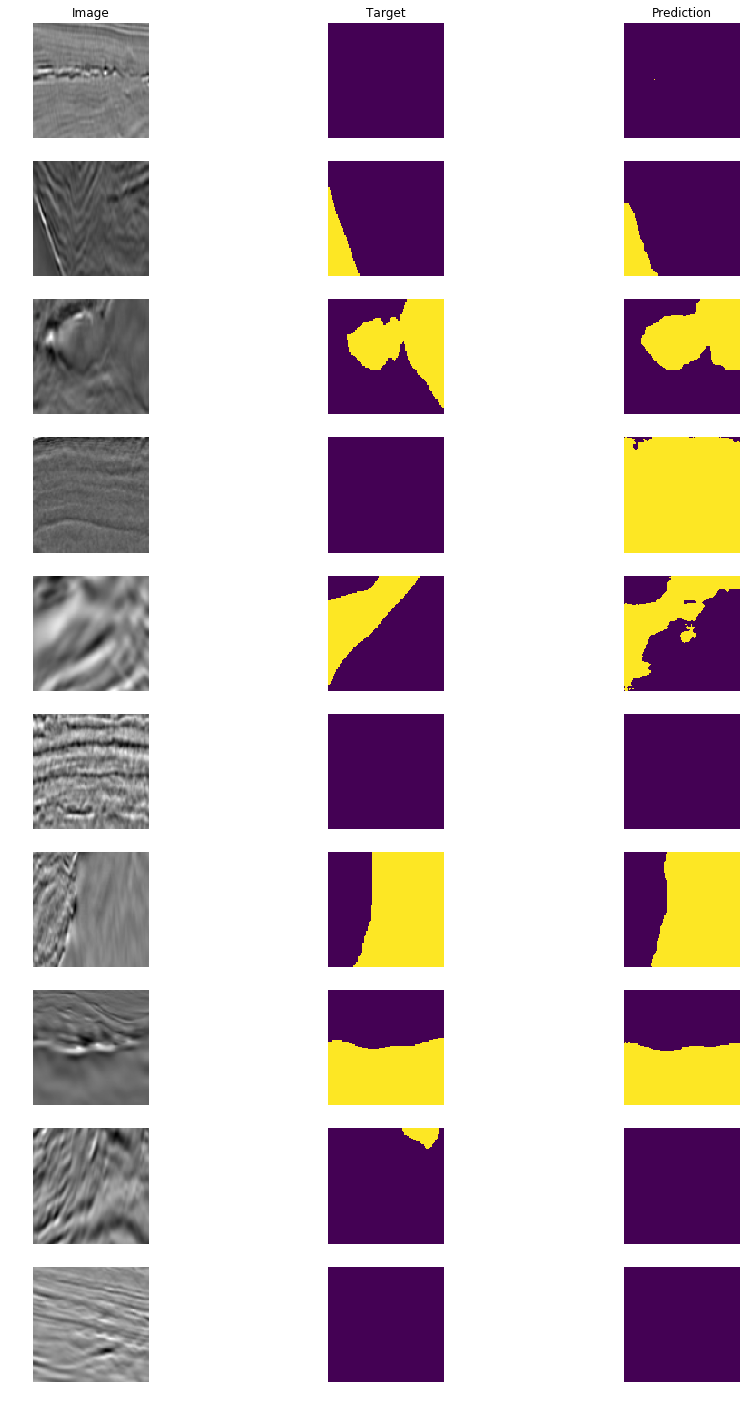

In [87]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

## Resnet34 Dynamic U-Net

The last model showed no real improvement. Next lets try fast.ai's implementation of a U-Net. This U-Net structure introduces several convolutions between the end of the encoder and the start of the decoder. Here is the source code from fast.ai:

In [ ]:
class DynamicUnet(nn.Module):
    """
    A dynamic implementation of Unet architecture, because calculating connections
    and channels suck!. When an encoder is passed, this network will
    automatically construct a decoder after the first single forward pass for any
    given encoder architecture.

    Decoder part is heavily based on the original Unet paper:
    https://arxiv.org/abs/1505.04597.

    Inputs:
        encoder(nn.Module): Preferably a pretrained model, such as VGG or ResNet
        last (bool): Whether to concat only last activation just before a size change
        n_classes (int): Number of classes to output in final step of decoder

    Important Note: If architecture directly reduces the dimension of an image as soon as the
    first forward pass then output size will not be same as the input size, e.g. ResNet.
    In order to resolve this problem architecture will add an additional extra conv transpose
    layer. Also, currently Dynamic Unet expects size change to be H,W -> H/2, W/2. This is
    not a problem for state-of-the-art architectures as they follow this pattern but it should
    be changed for custom encoders that might have a different size decay.
    """

    def __init__(self, encoder, last=True, n_classes=3):
        super().__init__()
        self.encoder = encoder
        self.n_children = len(list(encoder.children()))
        self.sfs = [SaveFeatures(encoder[i]) for i in range(self.n_children)]
        self.last = last
        self.n_classes = n_classes

    def forward(self, x):
        # get imsize
        imsize = x.size()[-2:]

        # encoder output
        x = F.relu(self.encoder(x))

        # initialize sfs_idxs, sfs_szs, middle_in_c and middle_conv only once
        if not hasattr(self, 'middle_conv'):
            self.sfs_szs = [sfs_feats.features.size() for sfs_feats in self.sfs]
            self.sfs_idxs = get_sfs_idxs(self.sfs, self.last)
            middle_in_c = self.sfs_szs[-1][1]
            middle_conv = nn.Sequential(*conv_bn_relu(middle_in_c, middle_in_c * 2, 3, 1, 1),
                                        *conv_bn_relu(middle_in_c * 2, middle_in_c, 3, 1, 1))
            self.middle_conv = middle_conv

        # middle conv
        x = self.middle_conv(x)

        # initialize upmodel, extra_block and 1x1 final conv
        if not hasattr(self, 'upmodel'):
            x_copy = Variable(x.data, requires_grad=False)
            upmodel = []
            for idx in self.sfs_idxs[::-1]:
                up_in_c, x_in_c = int(x_copy.size()[1]), int(self.sfs_szs[idx][1])
                unet_block = UnetBlock(up_in_c, x_in_c)
                upmodel.append(unet_block)
                x_copy = unet_block(x_copy, self.sfs[idx].features)
                self.upmodel = nn.Sequential(*upmodel)

            if imsize != self.sfs_szs[0][-2:]:
                extra_in_c = self.upmodel[-1].conv2.out_channels
                self.extra_block = nn.ConvTranspose2d(extra_in_c, extra_in_c, 2, 2)

            final_in_c = self.upmodel[-1].conv2.out_channels
            self.final_conv = nn.Conv2d(final_in_c, self.n_classes, 1)

        # run upsample
        for block, idx in zip(self.upmodel, self.sfs_idxs[::-1]):
            x = block(x, self.sfs[idx].features)
        if hasattr(self, 'extra_block'):
            x = self.extra_block(x)

        out = self.final_conv(x)

        if self.n_classes == 1:
            out = out.squeeze(1)

        return out

In [63]:
from fastai.models.unet import *

In [64]:
def get_encoder(f, cut):
    base_model = (cut_model(f(True), cut))
    return nn.Sequential(*base_model)

In [65]:
encoder = get_encoder(f, 8)

m = DynamicUnet(encoder, n_classes=1)

In [66]:
inp = torch.ones(1, 3, 128, 128)
out = m(V(inp).cpu())

In [67]:
out.shape

torch.Size([1, 128, 128])

In [68]:
m = m.cuda(1)

In [69]:
class UpsampleModel():
    def __init__(self, model, cut_lr, name='upsample'):
        self.model,self.name, self.cut_lr = model, name, cut_lr

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.encoder), [self.cut_lr]))
        return lgs + [children(self.model)[1:]]

In [70]:
models = UpsampleModel(m, cut_lr=6)

In [71]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5), dice, IoU]

In [72]:
learn.freeze_to(1)

 58%|████████████████████████████████████████▎                             | 65/113 [00:09<00:07,  6.57it/s, loss=1.68]

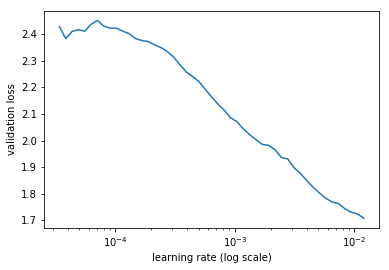

In [87]:
learn.lr_find()
learn.sched.plot()

In [98]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [99]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.16043    1.766461   0.833895   0.517327   0.353233  
    1      1.003278   0.929957   0.89313    0.739104   0.5911                                                          
    2      0.830419   1.02272    0.8796     0.679542   0.523008                                                        
    3      0.813469   0.799121   0.898306   0.774274   0.637578                                                        
    4      0.792814   0.970464   0.868786   0.671678   0.513033                                                        
    5      0.716804   0.848178   0.882385   0.714629   0.562732                                                        
    6      0.670728   0.873964   0.885245   0.719139   0.568851                                                        
    7      0.624964   0.584512   0.92196    0.825544   0.706979                               

[0.5213313686847687,
 0.9283558654785157,
 0.8401204514503479,
 0.7297639536857605]

In [100]:
learn.unfreeze()
learn.bn_freeze(True)

In [101]:
learn.fit(lrs/20, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.440814   0.515131   0.932711   0.846271   0.739536  
    1      0.489625   0.499215   0.935107   0.855699   0.752039                                                        
    2      0.471192   0.502113   0.933077   0.848641   0.742452                                                        
    3      0.442642   0.524102   0.93083    0.844538   0.735245                                                        
    4      0.428725   0.495889   0.934554   0.85202    0.746943                                                        
    5      0.425505   0.492004   0.934594   0.854542   0.750933                                                        
    6      0.422107   0.485856   0.934985   0.856104   0.753311                                                        
    7      0.433301   0.487434   0.934539   0.855465   0.752493                               

[0.49069036841392516,
 0.9344393920898437,
 0.853022632598877,
 0.7487449955940246]

The Dynamic U-Net model seems slightly worse than the basic U-Net model.

Prediction masks:

In [102]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

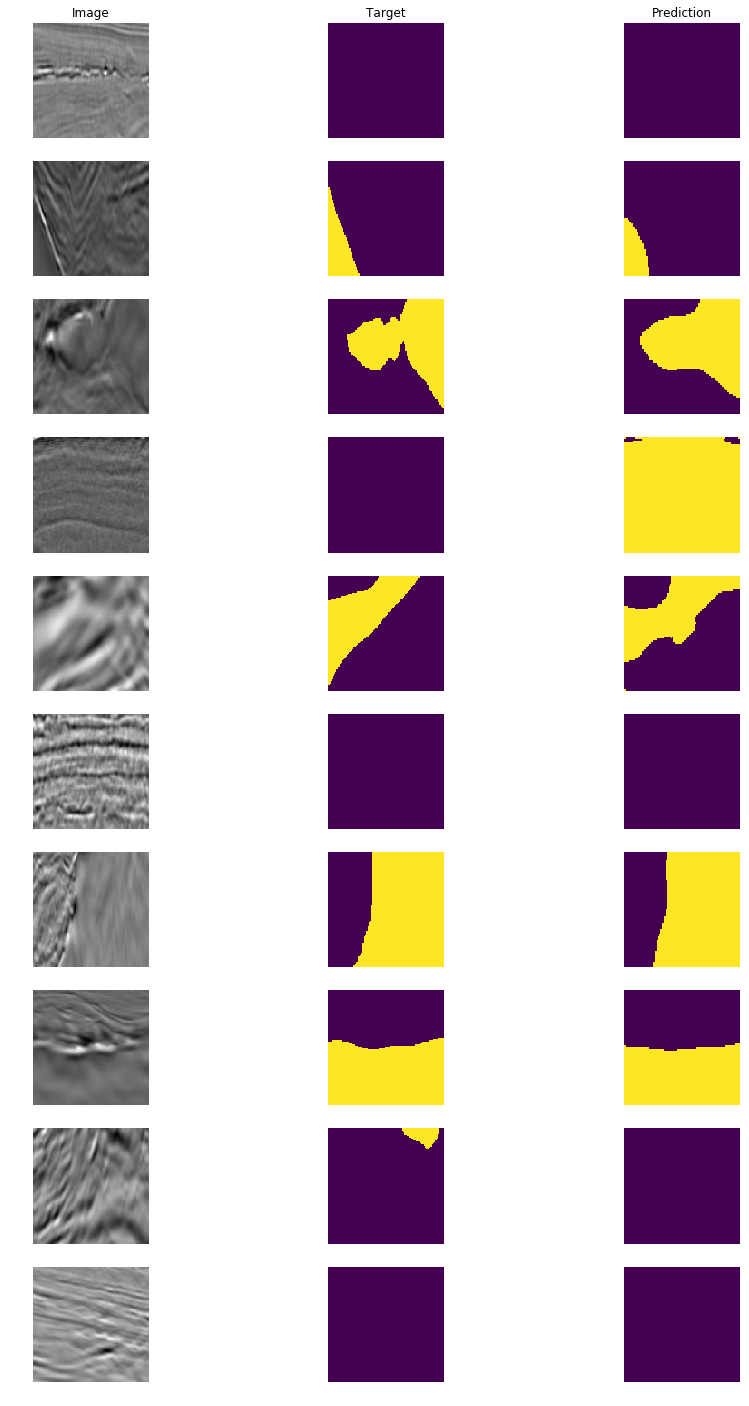

In [103]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

This is interesting. Firstly we saw 3 different resent34 based models make predictions, and the same failures for the same images were present in all of them. That suggests issues with the encoder rather than the decoder.

The Dynamic U-Net model performs slightly worse than previous models. We can see this in the mask predictions - they are blobbier and less defines.

# 4. VGG16 Models

Our previous models used Resnet34 as an encoder. Now we're going to try the same decoder architectures with a VGG16 encoder.

First the simple decoder:

In [73]:
sz = 128
bs = 16
#Create a new model data object that has the right image normalization for VGG16
tfms = tfms_from_model(vgg16, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [74]:
f = vgg16
cut,lr_cut = model_meta[f]

In [75]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [76]:
class Unet_VGG(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [5, 12, 22, 32, 42]]
        self.up1 = UnetBlock(512, 512, 256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,128,256)
        self.up5 = UnetBlock(256,64,256)
        self.up6 = nn.Conv2d(256, 1, 3, stride=1, padding=1)
                
    def forward(self,x):
        x = self.rn(x)
        x = self.up1(x, self.sfs[4].features)
        x = self.up2(x, self.sfs[3].features)
        x = self.up3(x, self.sfs[2].features)
        x = self.up4(x, self.sfs[1].features)
        x = self.up5(x, self.sfs[0].features)
        x = self.up6(x)
        return x.squeeze(1)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [77]:
m = to_gpu(Unet_VGG(vgg16(True)))

models = UnetModel(m)

In [78]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5),dice]

In [79]:
learn.freeze_to(1)

 72%|█████████████████████████████████████████████████▋                   | 162/225 [00:25<00:09,  6.46it/s, loss=4.25]

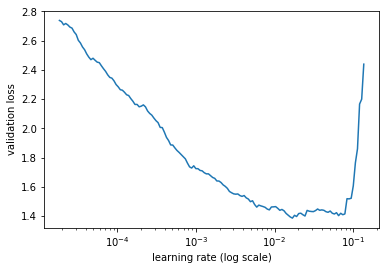

In [116]:
learn.lr_find()
learn.sched.plot()

In [80]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [81]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.951794   0.787273   0.904073   0.766441  
    1      0.831382   0.670032   0.919379   0.800655                                                                   
    2      0.738406   0.557257   0.92898    0.829948                                                                   
    3      0.657519   0.666938   0.920785   0.795439                                                                   
    4      0.616666   0.553505   0.929842   0.836491                                                                   
    5      0.608604   0.532589   0.928447   0.834731                                                                   
    6      0.582237   0.511624   0.931319   0.842251                                                                   
    7      0.488877   0.511502   0.932072   0.841499                                                     

[0.45089687407016754, 0.9397737121582032, 0.862710349559784]

In [82]:
learn.unfreeze()
learn.bn_freeze(True)

In [83]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.46233    0.488442   0.93888    0.857174  
    1      0.440487   0.475151   0.935725   0.85413                                                                    
    2      0.388944   0.516951   0.937888   0.855312                                                                   
    3      0.383325   0.49129    0.938379   0.852456                                                                   
    4      0.401377   0.468025   0.93949    0.857912                                                                   
    5      0.391603   0.46644    0.937421   0.858166                                                                   
    6      0.343589   0.465207   0.941623   0.865132                                                                   
    7      0.36632    0.475904   0.938493   0.857483                                                     

[0.45031404972076416, 0.940550537109375, 0.8601696014404296]

VGG16 based prediction masks

In [84]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

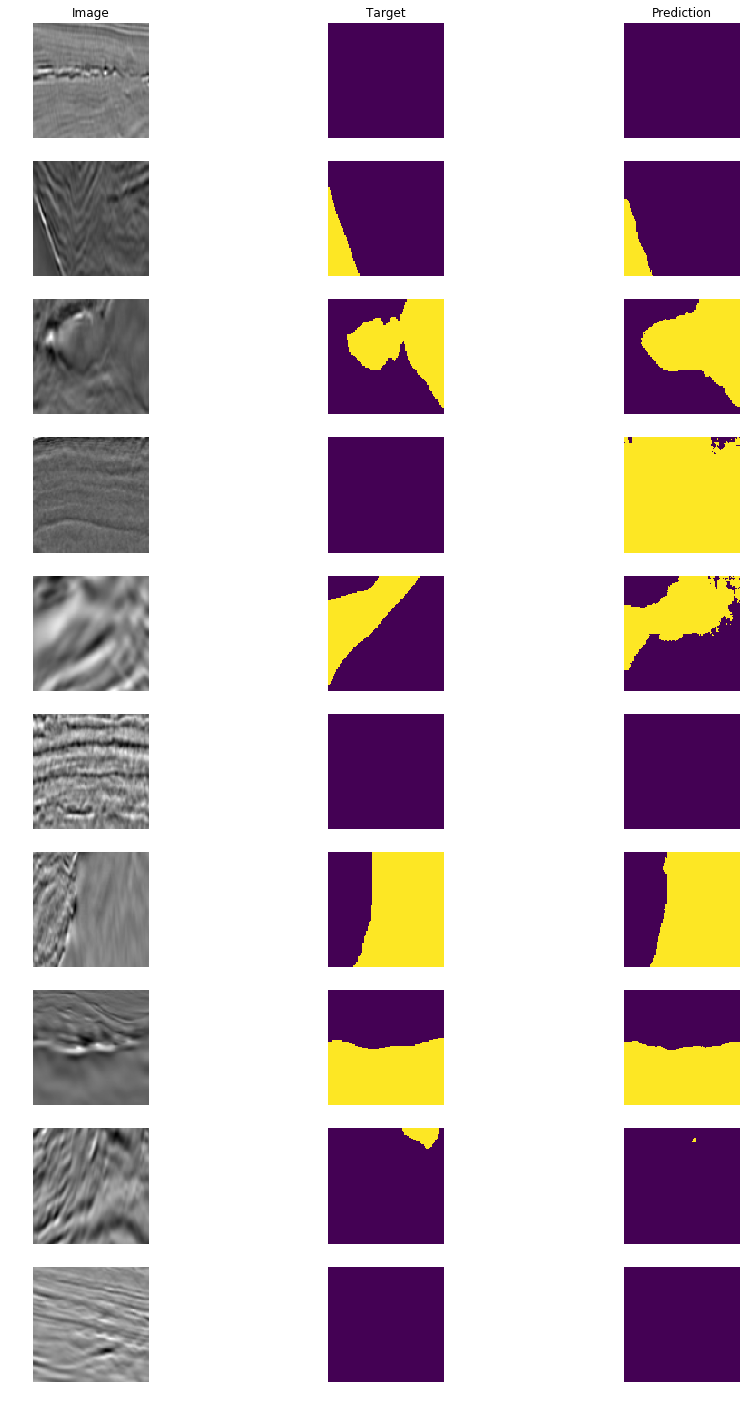

In [85]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

VGG masks seem to have more visual static. Now lets try adding some more final convolutions.

## VGG16 Deeper Decoder

In [80]:
def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return nn.Sequential(*[
                        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.ReLU(),
                        nn.BatchNorm2d(out_c)])

In [81]:
class Unet_VGG_2(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [5, 12, 22, 32, 42]]
        self.up1 = UnetBlock(512, 512, 256)
        self.up2 = UnetBlock(256,512,256)
        self.up3 = UnetBlock(256,256,256)
        self.up4 = UnetBlock(256,128,256)
        self.up5 = UnetBlock(256,64,128)
        
        self.conv1 = conv_bn_relu(128, 64, 3, 1, 1)
        self.conv2 = conv_bn_relu(64, 64, 3, 1, 1)
        self.conv3 = conv_bn_relu(64, 1, 1, 1, 0)
        
                
    def forward(self,x):
        x = self.rn(x)
        x = self.up1(x, self.sfs[4].features)
        x = self.up2(x, self.sfs[3].features)
        x = self.up3(x, self.sfs[2].features)
        x = self.up4(x, self.sfs[1].features)
        x = self.up5(x, self.sfs[0].features)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x.squeeze(1)
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [82]:
m = to_gpu(Unet_VGG_2(vgg16(True)))

models = UnetModel(m)

In [83]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5), dice, IoU]

In [84]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.36242    1493.554307 0.238556   0.371622   0.233888  



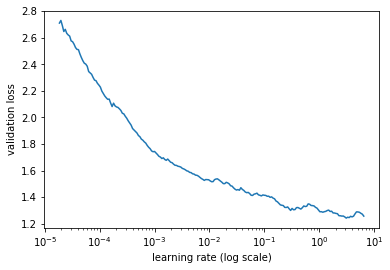

In [91]:
learn.lr_find()
learn.sched.plot()

In [92]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [93]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.009218   0.896992   0.900941   0.763979   0.627326  
    1      0.794526   0.774783   0.91252    0.783874   0.653668                                                        
    2      0.734604   0.586741   0.926711   0.825806   0.713838                                                        
    3      0.728307   0.590626   0.927801   0.821867   0.706063                                                        
    4      0.623828   0.58263    0.932907   0.832576   0.72306                                                         
    5      0.573095   0.55445    0.932009   0.839742   0.734512                                                        
    6      0.551416   0.587794   0.930332   0.827315   0.717406                                                        
    7      0.551523   0.502418   0.938347   0.855555   0.759301                               

[0.48464829921722413,
 0.9345188903808593,
 0.848508849143982,
 0.7470830917358399]

In [94]:
learn.unfreeze()
learn.bn_freeze(True)

In [95]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.441205   0.486195   0.939533   0.857658   0.761356  
    1      0.415703   0.448741   0.942251   0.86678    0.775051                                                        
    2      0.384989   0.478177   0.936948   0.855134   0.755212                                                        
    3      0.384626   0.458747   0.941613   0.86953    0.778911                                                        
    4      0.392201   0.432826   0.942189   0.869681   0.776959                                                        
    5      0.35511    0.453501   0.939885   0.859363   0.762821                                                        
    6      0.401551   0.444129   0.941294   0.868043   0.778075                                                        
    7      0.341505   0.433253   0.941862   0.869205   0.77695                                

[0.4267104882001877,
 0.9421424865722656,
 0.8701836776733398,
 0.7792334282398223]

In [96]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

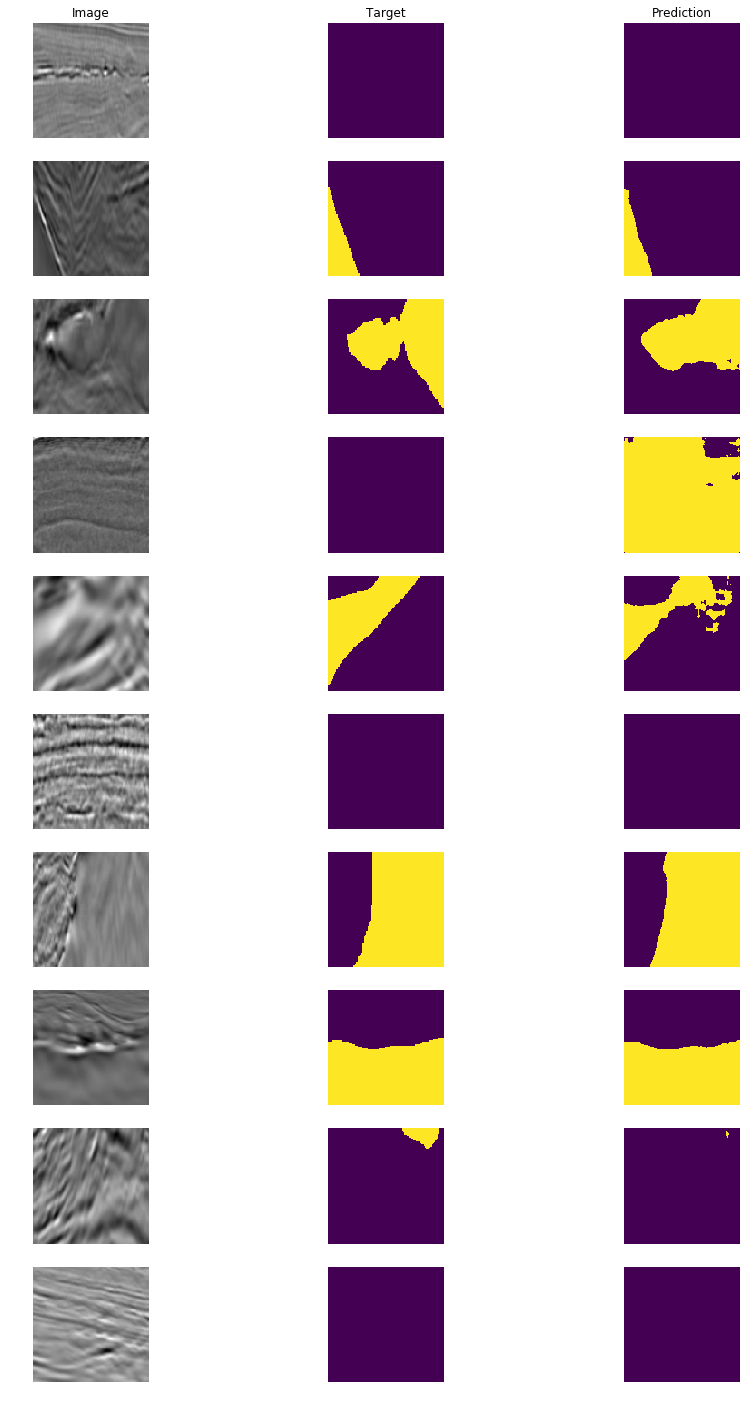

In [97]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

In general VGG16 seems to produce worse masks. Lets try the Dynamic U-Net model with VGG16.

## Dynamic U-Net VGG16

In [85]:
from fastai.models.unet import *

In [86]:
encoder = get_encoder(f, 30)
m = DynamicUnet(encoder, n_classes=1)

In [87]:
inp = torch.ones(1, 3, 128, 128)
out = m(V(inp).cpu())

In [88]:
out.shape

torch.Size([1, 128, 128])

In [89]:
m = m.cuda(1)

In [90]:
models = UpsampleModel(m, cut_lr=26)

In [91]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5),dice]

In [92]:
learn.freeze_to(1)

 84%|███████████████████████████████████████████████████████████           | 190/225 [00:31<00:05,  6.08it/s, loss=2.4]

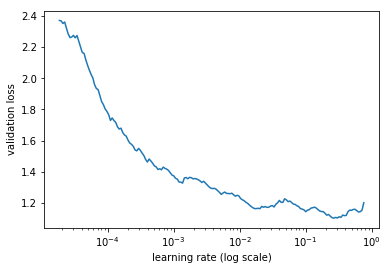

In [107]:
learn.lr_find()
learn.sched.plot()

In [93]:
lr=1e-2
wd=2e-7

lrs = np.array([lr/100,lr/10,lr])

In [94]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.85034    0.697916   0.916773   0.799979  
    1      0.72288    0.602859   0.921519   0.816215                                                                   
    2      0.667084   0.594275   0.925203   0.836451                                                                   
    3      0.614469   0.572652   0.920262   0.816453                                                                   
    4      0.63137    0.552271   0.93441    0.84571                                                                    
    5      0.554443   0.557693   0.925771   0.831187                                                                   
    6      0.504178   0.511609   0.932432   0.841883                                                                   
    7      0.552472   0.493827   0.936107   0.850742                                                     

[0.5144772958755494, 0.9322947692871094, 0.8411635494232178]

In [95]:
learn.unfreeze()
learn.bn_freeze(True)

In [96]:
learn.fit(lrs/15, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.420501   0.513833   0.936173   0.849753  
    1      0.402264   0.471741   0.941443   0.86236                                                                    
    2      0.409461   0.484683   0.938228   0.857265                                                                   
    3      0.381698   0.482748   0.936156   0.853484                                                                   
    4      0.480672   0.476659   0.936889   0.856142                                                                   
    5      0.407745   0.470979   0.939377   0.858371                                                                   
    6      0.375271   0.464043   0.940005   0.860668                                                                   
    7      0.359968   0.465889   0.940831   0.861777                                                     

[0.47063311338424685, 0.9399905395507813, 0.8603280377388001]

In [97]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

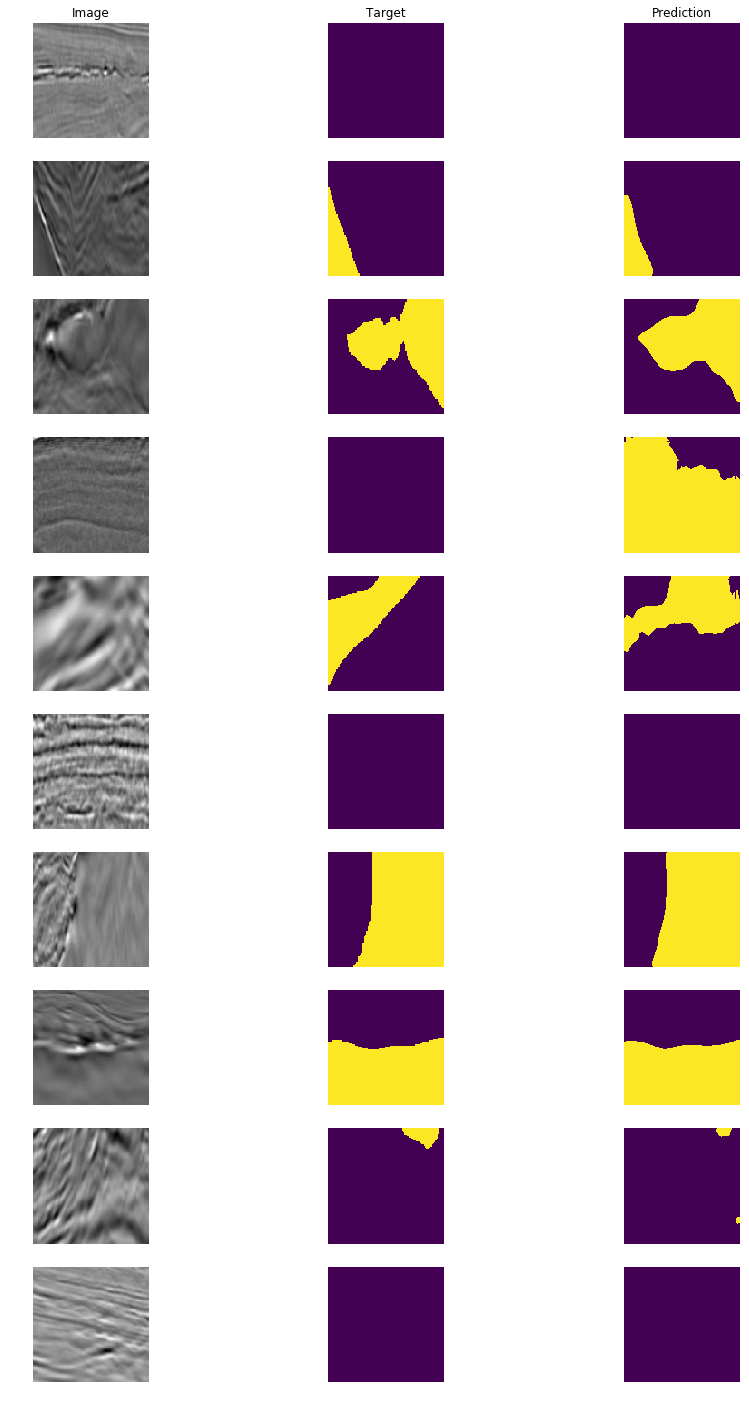

In [98]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

These masks look better than the previous VGG models.

# 5. Resnext50 Models

There's one more encoder I'd like to try - Resnext50. It's a heavier model compared to Resnet34. Lets see how it works with the three decoders we've been trying.

## Resnext50 Simple Decoder

In [73]:
sz = 128
bs = 32

tfms = tfms_from_model(resnext50, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [74]:
f = resnext50
cut,lr_cut = model_meta[f]

In [75]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [76]:
class Unet50(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,1024)
        self.up2 = UnetBlock(1024,512,512)
        self.up3 = UnetBlock(512,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [77]:
m_base = get_base()
m = to_gpu(Unet50(m_base))
models = UnetModel(m)

In [78]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5),dice]

In [79]:
learn.freeze_to(1)

 78%|██████████████████████████████████████████████████████▌               | 88/113 [00:17<00:04,  5.04it/s, loss=1.38]

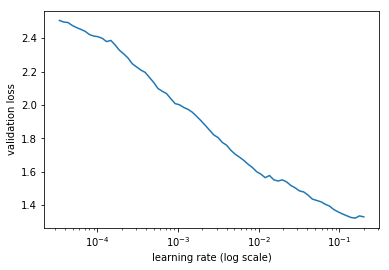

In [108]:
learn.lr_find()
learn.sched.plot()

In [109]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [110]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.847007   0.995649   0.896977   0.773983  
    1      0.701355   0.55736    0.928078   0.833137                                                                   
    2      0.612394   0.568592   0.925607   0.832075                                                                   
    3      0.563033   0.497889   0.93904    0.864256                                                                   
    4      0.506829   0.513486   0.936735   0.856299                                                                   
    5      0.497919   0.512118   0.937791   0.861508                                                                   
    6      0.469521   0.492876   0.935135   0.853437                                                                   
    7      0.446812   0.451347   0.940805   0.873844                                                     

[0.44943571865558624, 0.9429325866699219, 0.8741768407821655]

In [111]:
learn.unfreeze()
learn.bn_freeze(True)

In [112]:
learn.fit(lrs/10, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice                                                                       
    0      0.325588   0.444275   0.943624   0.87475   
    1      0.326734   0.488967   0.937188   0.864924                                                                   
    2      0.319993   0.452373   0.9451     0.88021                                                                    
    3      0.316152   0.445438   0.943636   0.876312                                                                   
    4      0.306827   0.446122   0.943448   0.877233                                                                   
    5      0.290493   0.459446   0.945189   0.88174                                                                    
    6      0.302597   0.427625   0.944296   0.879781                                                                   
    7      0.28049    0.442481   0.946488   0.883413                                                     

[0.4395812165737152, 0.9455873107910157, 0.8847931861877442]

In [114]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

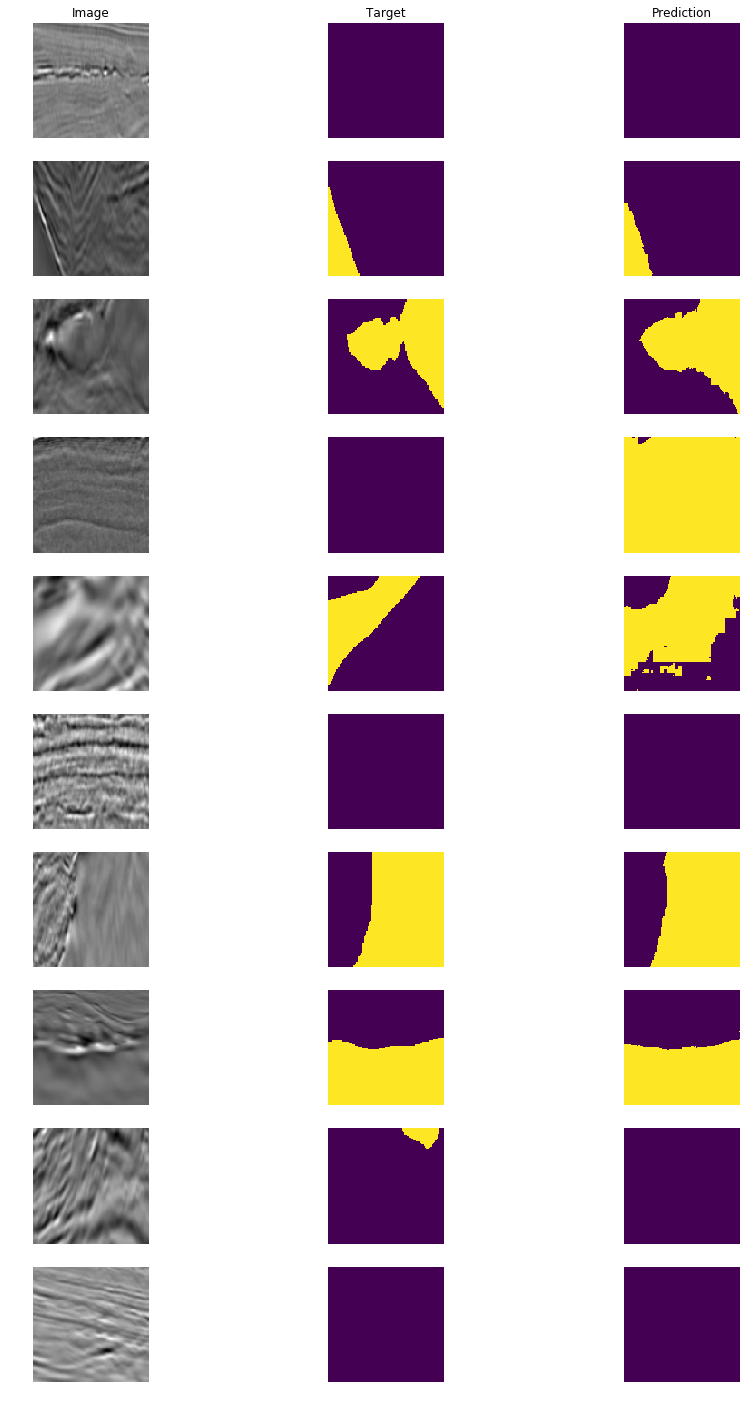

In [115]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

Resnext50 seems on par with Resnet34, but no better.

## Resnext50 Deeper Decoder

In [80]:
def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return nn.Sequential(*[
                        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.ReLU(),
                        nn.BatchNorm2d(out_c)])

In [81]:
class Unet50_2(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(2048,1024,1024)
        self.up2 = UnetBlock(1024,512,512)
        self.up3 = UnetBlock(512,256,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        self.conv1 = conv_bn_relu(128, 64, 3, 1, 1)
        self.conv2 = conv_bn_relu(64, 64, 3, 1, 1)
        self.conv3 = conv_bn_relu(64, 1, 1, 1, 0)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [82]:
m_base = get_base()
m = to_gpu(Unet50_2(m_base))
models = UnetModel(m)

In [83]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5), dice, IoU]

In [84]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.237763   1903.872266 0.70219    0.353234   0.214715  



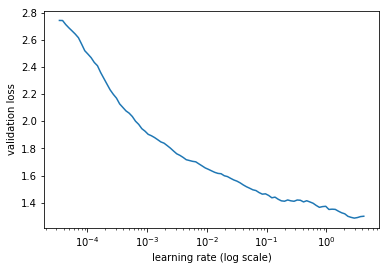

In [105]:
learn.lr_find()
learn.sched.plot()

In [106]:
lr=1e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [107]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      1.08064    0.818657   0.925609   0.817973   0.697456  
    1      0.801914   0.861042   0.899316   0.769577   0.628878                                                        
    2      0.679172   0.600433   0.929436   0.84128    0.731398                                                        
    3      0.614436   0.538281   0.93301    0.848465   0.742118                                                        
    4      0.553382   0.528083   0.934617   0.847065   0.74078                                                         
    5      0.531409   0.48878    0.940636   0.866427   0.769335                                                        
    6      0.503928   0.482342   0.93703    0.858884   0.758305                                                        
    7      0.47015    0.49272    0.93906    0.861507   0.7627                                 

[0.4639387607574463, 0.941702880859375, 0.8731377577781677, 0.7805197215080262]

In [108]:
learn.unfreeze()
learn.bn_freeze(True)

In [109]:
learn.fit(lrs/10, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.350068   0.46426    0.939666   0.866707   0.770125  
    1      0.356057   0.477006   0.943342   0.876406   0.786015                                                        
    2      0.368932   0.44347    0.94448    0.87779    0.788306                                                        
    3      0.348514   0.479543   0.938589   0.867783   0.772127                                                        
    4      0.330953   0.454037   0.9407     0.871003   0.777241                                                        
    5      0.328571   0.451502   0.94325    0.876693   0.786921                                                        
    6      0.335577   0.453215   0.937542   0.865274   0.767529                                                        
    7      0.324017   0.443906   0.941964   0.874736   0.782531                               

[0.44057225704193115, 0.943914794921875, 0.878238160610199, 0.7890760016441345]

In [110]:
x, y = next(iter(md.val_dl))

mod = learn.model.eval()
p = mod(V(x))

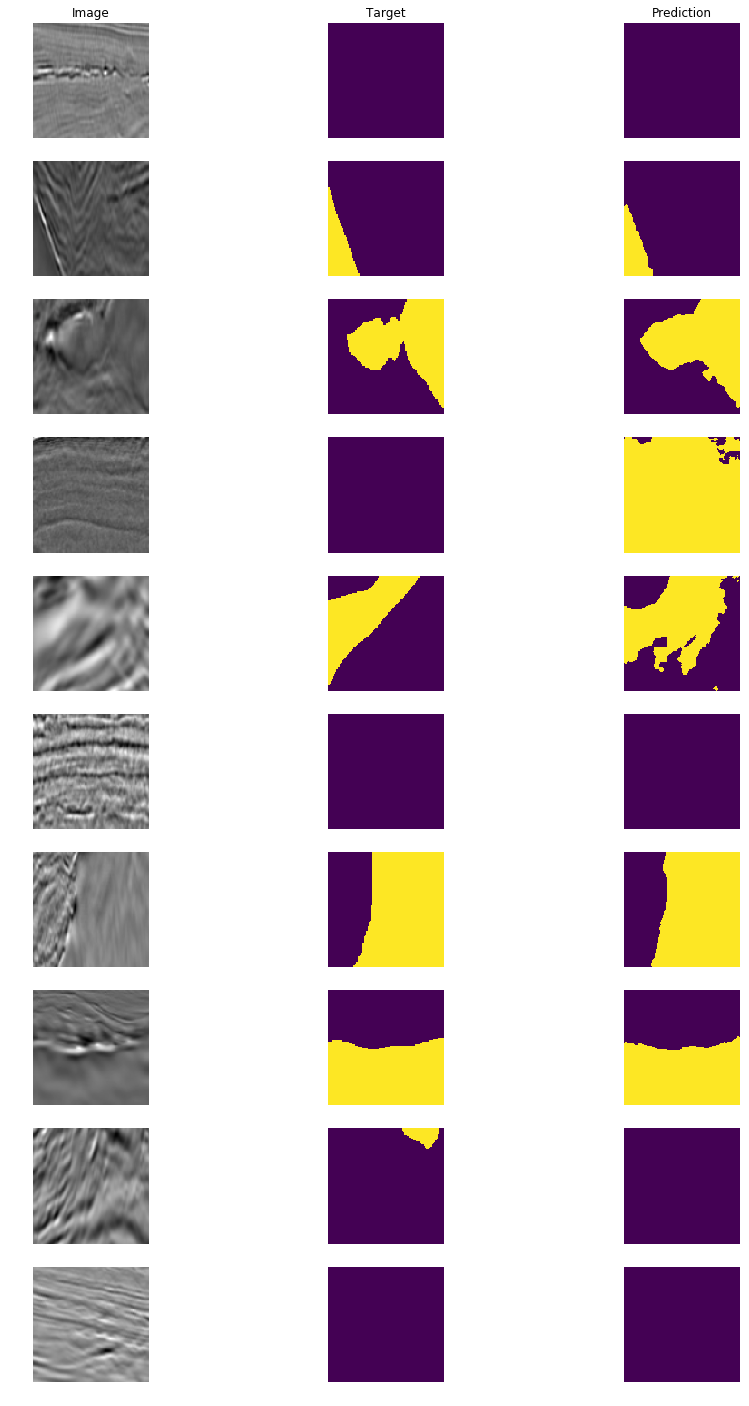

In [111]:
fig, axes = plt.subplots(10 , 3, figsize = (15,25))

cols = ['Image', 'Target', 'Prediction']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(10):
    axes[i][0] = show_img(denorm(x[i+5]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i+5], ax = axes[i][1])
    axes[i][2] = show_img(to_np(p[i+5].data > 0), ax = axes[i][2])

The dice score for this model is on par with others, but some of the masks look really ugly.

## Resnext50 Dynamic U-Net

This was way too heavy for my GPU to handle. Given the architecture of Resnext50, the Dynamic U-Net model filled up with a ton of convolutional layers with 1024 or 2048 channels. My GPU did not enjoy that.

# 6. Prediction

Now it's time to make a prediction on the test set. I've decided to use Resnet34 with the deeper decoder. It was on par with Resnext50 for performance on the validation set without being as heavy. To get the best performance, we will retrain the model exactly as before but with the entire dataset.

The callbacks will still print a validation error, but this value will be with respect to a single holdout image and is not representative.

In [58]:
val_idxs = get_cv_idxs(n, val_pct=0.001)

In [59]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [60]:
TEST_DN = 'test/images'

In [61]:
test_fns = os.listdir(PATH/TEST_DN)

In [62]:
test_names = np.array([Path(TEST_DN)/o for o in test_fns])

In [63]:
test_y = np.random.choice(y_names, len(test_names))

In [64]:
sz = 128
bs = 32

tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, 
                                 test=(test_names, test_y), path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [65]:
def conv_bn_relu(in_c, out_c, kernel_size, stride, padding):
    return nn.Sequential(*[
                        nn.Conv2d(in_c, out_c, kernel_size=kernel_size, stride=stride, padding=padding),
                        nn.ReLU(),
                        nn.BatchNorm2d(out_c)])

In [66]:
class Unet34_2(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        
        self.conv1 = conv_bn_relu(128, 64, 3, 1, 1)
        self.conv2 = conv_bn_relu(64, 64, 3, 1, 1)
        self.conv3 = conv_bn_relu(64, 1, 1, 1, 0)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [67]:
m_base = get_base()
m = to_gpu(Unet34_2(m_base))
models = UnetModel(m)

In [68]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = dice_loss
learn.metrics=[accuracy_thresh(0.5)]

In [69]:
learn.freeze_to(1)

In [70]:
lr=2e-2
wd=1e-6

lrs = np.array([lr/100,lr/10,lr])

In [71]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>                                                                              
    0      1.057427   1.012854   0.938568  
    1      0.820194   0.530929   0.97467                                                                               
    2      0.700393   0.269712   0.986282                                                                              
    3      0.632868   0.394052   0.985275                                                                              
    4      0.59835    0.262135   0.982849                                                                              
    5      0.58426    0.141002   0.989014                                                                              
    6      0.524241   0.195112   0.987198                                                                              
    7      0.488469   0.194967   0.98378                                                                            

[0.16937300562858582, 0.9837493896484375]

In [72]:
learn.unfreeze()
learn.bn_freeze(True)

In [73]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>                                                                              
    0      0.407937   0.150606   0.986572  
    1      0.423674   0.344894   0.98761                                                                               
    2      0.422477   0.224726   0.982559                                                                              
    3      0.374822   0.174463   0.983582                                                                              
    4      0.406586   0.197721   0.980942                                                                              
    5      0.362131   0.126518   0.987946                                                                              
    6      0.376812   0.204692   0.985428                                                                              
    7      0.362815   0.176516   0.989563                                                                           

[0.16427211463451385, 0.98583984375]

In [74]:
#Make prediction
preds = learn.predict_dl(md.test_dl)

In [75]:
len(preds)

18000

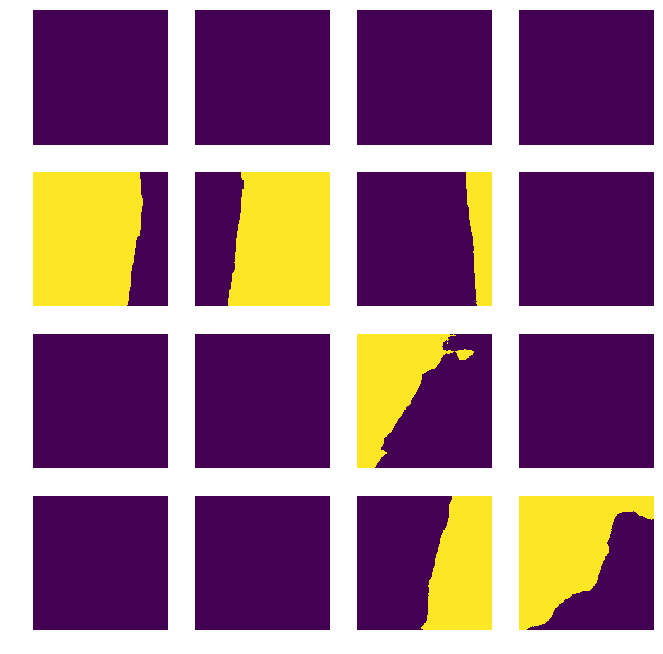

In [90]:
fig, axes = plt.subplots(4, 4, figsize=(9, 9))
for i,ax in enumerate(axes.flat):
    show_img(preds[i] > 0.5, ax=ax)
plt.tight_layout(pad=0.1)

In [79]:
ims = [open_image(PATH/test_names[i]) for i in range(16)]

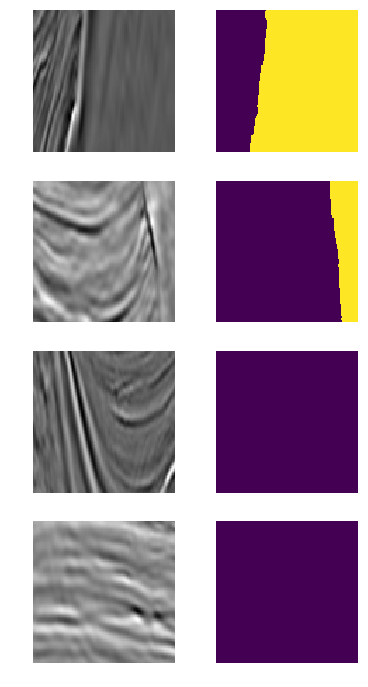

In [89]:
fig, axes = plt.subplots(4 , 2, figsize = (6,12))

for i in range(4):
    axes[i][0] = show_img(ims[i+5], ax = axes[i][0])
    axes[i][1] = show_img(preds[i+5] > 0.5, ax = axes[i][1])

Now we convert the predicted masks into RLE encoded strings. I don't know the origin of this function but it has been passed around a number of Kaggle kernels.

In [88]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [92]:
encoded_preds = {}
for i, (p, fn) in enumerate(zip(preds, md.test_ds.fnames)):
    
    im_mask = (cv2.resize(p, dsize=(101, 101), interpolation=cv2.INTER_CUBIC)>0.5)
    file = str(fn).split('\\')[-1]
    rle = RLenc(im_mask)
    encoded_preds[file] = rle 

In [101]:
df_preds = pd.DataFrame.from_dict(encoded_preds, orient='index')
df_preds.reset_index(inplace=True)
df_preds.columns = ['id', 'rle_mask']
df_preds.id = df_preds.id.apply(lambda x: x[:-4])

In [102]:
df_preds.head(10)

,id,rle_mask
0,0005bb9630,
1,000a68e46c,
2,000c8dfb2a,
3,000d0a5f6c,
4,001ef8fc87,1 7170 7172 97 7273 88 7374 76 7475 71 7576 65...
5,002124aa19,2523 3 2615 12 2715 13 2808 21 2905 25 3004 27...
6,002af5d1e8,8183 11 8283 26 8384 29 8416 1 8485 39 8586 46...
7,00323f1910,
8,00329dc15c,
9,0035c56490,


In [107]:
df_preds.to_csv('salt_submission.csv', index=False)

This submission scored 0.735 on the public leaderboard, scored by IoU.

We can also apply post-processing techniques to improve the masks. We will use a function that uses conditional random fields to smooth out the masks, taken from this [Kaggle kernel](https://www.kaggle.com/meaninglesslives/apply-crf)

In [109]:
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray

In [110]:
"""
Function which returns the labelled image after applying CRF

"""
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [156]:
def rle_decode(rle_mask):
    '''
    rle_mask: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = rle_mask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(101*101, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(101,101).T

In [168]:
encoded_preds2 = {}
for i, (p, fn) in enumerate(zip(preds, md.test_ds.fnames)):
    
    im_orig = imread(PATH/fn)
    im_mask = (cv2.resize(p, dsize=(101, 101), interpolation=cv2.INTER_CUBIC)>0.5)
    img_crf = crf(im_orig, im_mask)
    rle = RLenc(img_crf)
    file = str(fn).split('\\')[-1]
    
    encoded_preds2[file] = rle

In [169]:
df_preds = pd.DataFrame.from_dict(encoded_preds2, orient='index')
df_preds.reset_index(inplace=True)
df_preds.columns = ['id', 'rle_mask']
df_preds.id = df_preds.id.apply(lambda x: x[:-4])

In [170]:
df_preds.head(10)

,id,rle_mask
0,0005bb9630,
1,000a68e46c,
2,000c8dfb2a,
3,000d0a5f6c,
4,001ef8fc87,1 7170 7172 97 7273 88 7374 76 7475 71 7576 65...
5,002124aa19,2523 3 2615 12 2715 13 2808 21 2905 25 3004 27...
6,002af5d1e8,8183 11 8283 26 8384 29 8416 1 8485 39 8586 46...
7,00323f1910,
8,00329dc15c,
9,0035c56490,


In [171]:
df_preds.to_csv('salt_submission_crf.csv', index=False)

This submission scored 0.744 on the public leaderboard, an increase from 0.735.

This shows exactly what crf is doing to the masks:

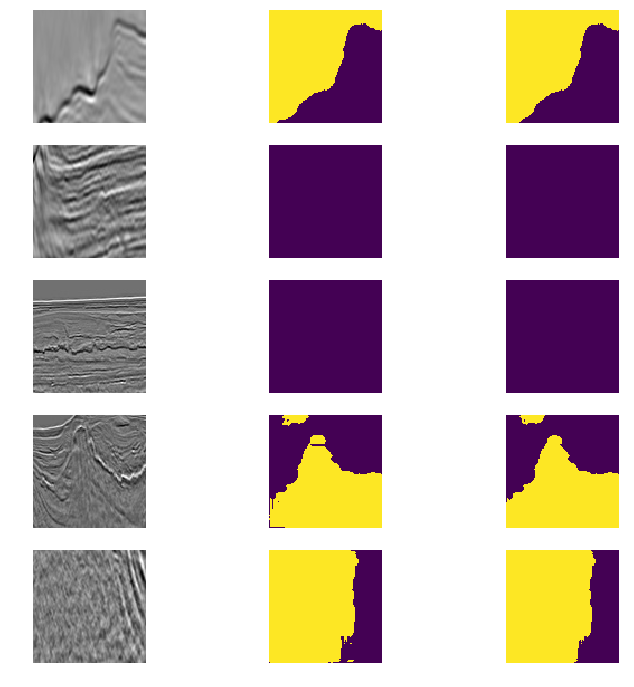

In [172]:
fig, axes = plt.subplots(5 , 3, figsize = (12,12))

for i in range(5):
    
    im_orig = imread(PATH/md.test_ds.fnames[i+15])
    im_mask = (cv2.resize(preds[i+15], dsize=(101, 101), interpolation=cv2.INTER_CUBIC)>0.5)
    img_crf = crf(im_orig, im_mask)
    
    axes[i][0] = show_img(im_orig, ax = axes[i][0])
    axes[i][1] = show_img(im_mask, ax = axes[i][1])
    axes[i][2] = show_img(img_crf, ax = axes[i][2])

# 7. Afterthoughts

This was a pretty fun competition. The size of the dataset made training a good model difficult, but also allowed for rapid iteration to explore different hyperparameters and architecture variants. I feel like I've got U-Nets figured out after all of this.

One thing that bugs me is how the public leaderboard score for my submissions (0.735, 0.744 IoU) were significantly lower than the values seen in training (0.78). I expect this difference is due to false positives on empty images. That's a hard problem to get around. Current leading public scores are around 0.87. I'm interested to see what sort of image processing they used to achieve those results.